# Preliminary remarks

Plagiat is strictly forbidden and will automatically be reported. Using tools from the Internet like Wikipedia, blogs or ChatGPT to better understand the subject is of course authorised and even encouraged. But the copy-pasting from such sources without any clear reference to it, including ChatGPT, is not.

The format of the project is a guided Jupyter notebook, similar to the format of the exercise sessions, but also including theoretical questions where you do not have to write code, but instead answer in English in a "Markdown cell". Those questions aim at verifying your understanding of the theoretical concepts as well as your ability to think critically and to provide clear explanations.  

For this project, you need to form **groups of 1 or 2 students** that you are free to choose. All the students belonging to the same group will get the same grade. The composition of the groups must be entered in [this excel file](https://universitelibrebruxelles.sharepoint.com/:x:/r/sites/Section_GEST-S420_202324/_layouts/15/Doc.aspx?sourcedoc=%7B2A4C5BFD-DDF5-474D-8E77-6E2A48472D69%7D&file=project_II_groups_compositions.xlsx&action=default&mobileredirect=true) before **Sunday May, 12th at 23:59**, date after which the composition of the groups cannot be modified. The group ID's should start at 1 and must be sequential. Please indicate in the cell *Identification* below the first name and last name of each member of your group, as well as the group ID and NOMAs.  

The deadline for this project is **Friday May, 31st at 23:59**. Late submissions will not be accepted. Your delivery must be sent via email to brieuc.roland@ulb.be with object "*Delivery Project 2 - Group *group_id*". The following **deliverables** (and only those) must be attached to the email:

1. This notebook (*.ipynb* format) with all your answers. All the code must have been executed and the output must be visible. We recommend to do it via the menu "Runtime > Restart and run all". The notebook needs to be self-sufficient (except for the provided data): with the original data files and your notebook, we need to be able to reproduce your results.

2. This notebook in a PDF format

**Notes**

1. We recommend you not to launch a "Restart and run all" at the last minute, as reexecuting everything may take a little bit of time. We also recommend you to make intermediate backups of your notebook (.ipynb and .pdf).

2. Most questions can be answered using only the course material (slides + notebooks from the exercise sessions), however a couple of questions may require you to perform extra research.

---

## Identification

**Group ID**: 5

**Member 1**: Selen, Thomas, 000474193

---

## Remarks

——— If you want to communicate general remarks about your work, you can write them here. ———

---

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [3]:
# some imports
import numpy as np
import os
import cv2
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity as cosine

# Project - Helping the IRCD with AI applications

You are in contact with "It's raining cats & dogs" shelters (IRCD) for their new strategy in 2025. Indeed, they are aware of what is possible with AI and they want to know more. Specifically, they want you to define what can be done with their own use case(s). You have several ideas, and want to showcase them, or with real usage of their data, or simply by describing what you want to do theoretically.  
As of now, the main problem is animal identification. As you guessed with the name, IRCD shelters are only dealing with cats and dogs. They would like to have a first application where new-comers are identified (among the different species existing) thanks to a picture that a refugee volunteer will took. Right now, you only have to prove that you can build a model that will make a distinction between cats and dogs.

The path `data` contains two folders: `train` and `test`. Those two folders then have the following structure:

```
- train
      - class_1
            - img_training_11.jpeg
            - img_training_12.jpeg
            - ...

      - ...

      - class_n
            - img_training_n1.jpeg
            - img_training_n2.jpeg
            - ...

- test
      - class_1
            - img_validation_11.jpeg
            - img_validation_12.jpeg
            - ...

      - ...

      - class_n
            - img_validation_n1.jpeg
            - img_validation_n2.jpeg
            - ...
```
The folders `train` and `test` contain one sub-folder per class of image, with the name of the sub-folder corresponding to the name of the class. In our case we only have 2 classes: **Cats** and **Dogs**. The function `create_dataset` is provided to you (below) and allows to create a labelled dataset from a folder `img_folder`.

It returns
* The (pre-processed) images themselves, in the form of a numpy array
* The labels associated to the images
* The names of the images (be careful, the names are not all unique)
* A unique identifier (hash) for each image, to overcome the fact that image names are not unique.

In [4]:
np.random.seed(1)

def create_dataset(img_folder, img_size=(224, 224)):

  images = []
  class_names = []
  image_names = []
  image_hashes = []

  for class_dir in os.listdir(img_folder):
    for img_name in os.listdir(os.path.join(img_folder, class_dir)):
      image_path = os.path.join(img_folder, class_dir,  img_name)
      image = cv2.imread(image_path) # BGR format
      image_hash = str(hash(image.tobytes()))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # RGB format
      image = cv2.resize(image, img_size,interpolation = cv2.INTER_AREA)
      images.append(image)
      class_names.append(class_dir)
      image_names.append(img_name)
      image_hashes.append(image_hash)

  images = np.asarray(images)
  class_names = np.asarray(class_names)
  image_names = np.asarray(image_names)
  image_hashes = np.asarray(image_hashes)

  perm = np.random.permutation(len(images))

  return images[perm], class_names[perm], image_names[perm], image_hashes[perm]

### ▶︎ Question 1
Use the function `create_dataset` to create respectively the training and test datasets.

In [5]:
train_img_folder = '/content/gdrive/My Drive/GESTS420/Project II/cats_dogs_light/train/'
test_img_folder = '/content/gdrive/My Drive/GESTS420/Project II/cats_dogs_light/test/'

img_data_train, class_names_train, image_names_train, image_hashes_train = create_dataset(train_img_folder)
img_data_test, class_names_test, image_names_test, image_hashes_test = create_dataset(test_img_folder)


You can execute the cell below to visualize some of the training images and their corresponding labels.

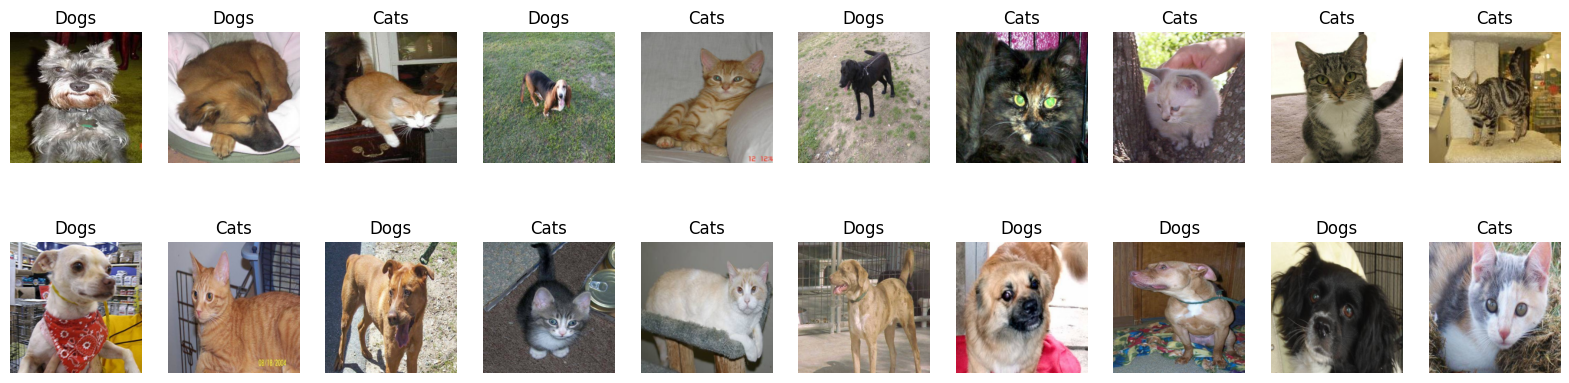

In [6]:
nrows = 2
ncols = 10
n_display = nrows * ncols
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 5))

for i in range(n_display):
    r = i // ncols
    c = i - r * ncols
    ax[r,c].title.set_text(class_names_train[i])
    img = img_data_train[i].astype(np.uint)
    ax[r,c].imshow(img)
    ax[r,c].axis('off')

### ▶︎ Question 2
Convert the textual labels into numerical labels (0 or 1). Compute this numerical label on both the training and the test sets.
During exercices, we used OneHotEncoder because we had more than two classes. Here, as it is binary, the output of our model will be a simple number and not an array. We can thus use `LabelEncoder()`. More specifically, you need to apply `fit_transform()` on training labels and `transform()` on test labels.

In [7]:
le = LabelEncoder()

# Fit and transform the training labels
train_labels = le.fit_transform(class_names_train)

# Transform the test labels
test_labels = le.transform(class_names_test)

In [8]:
le.classes_

array(['Cats', 'Dogs'], dtype='<U4')

Expected output when running above cell:  
`array(['Cats', 'Dogs'], dtype='<U4')`

### ▶︎ Question 3
Why don't we need to apply the same function on training and test labels?


--------------------------------------------------------------------------------
Because the two functions do not perform exactly the same task, the first function (`fit_transform`) performs two operations. First, it maps the textual label to a binary label (`fit`). For example, it will map 'dogs' to the binary variable '0'. Then, the second part of the function (`transform`) applies the transformation from the textual label to the numerical label.

The reason we do not reuse `fit` for the `test_labels` is that the mapping has already been done previously, so we simply use the already established mapping. It would even be risky to reuse the `fit` function to perform a second mapping because we could end up with a different mapping from the first one, leading to an inconsistency in our code. Additionally, we could also encounter an overfitting issue since we would be relearning a relationship that has already been learned by our code. This would not be representative of the real world.

--------------------------------------------------------------------------------

### ▶︎ Question 4
You want to show to IRCD board how powerfull are CNNs. In a first time, you will create a very simple one:  
 - A first layer consisting of 16 convolution filters of shape 3x3 each, with relu activation. Do not forget to specify the input shape of your images, as it is the first layer.
 - A second layer that will reduce the activation by computing the average of each "zone". It is the same idea than a MaxPooling layer, the only change is the operation done. Use a size of (2,2).
 - You are afraid of overfitting, thus you will add a layer that keeps only 85% of weights learnt (i.e. a layer that sets 15% of the weights to 0).
 - A fourth layer that flatten everything
 - The final layer that makes the prediction possible, with a softmax activation.  

After that, call the function with the good parameters.  
Finally, fit the CNN to your data.

In [9]:
import keras
from keras.models import Sequential
from keras.layers import Conv2D, AveragePooling2D, Dropout, Flatten, Dense
from keras.optimizers import RMSprop
def define_model(input_shape, n_classes=10):

    model = Sequential()

    # Première couche de convolution
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape))

    # AveragePooling
    model.add(AveragePooling2D(pool_size=(2, 2)))

    # Dropout
    model.add(Dropout(0.15))

    # Flatten
    model.add(Flatten())

    # Sigmoid for binary classification
    model.add(Dense(1, activation='sigmoid'))

    # Compiling the model
    opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [10]:
# 224x224 images with 3 channels
input_shape = (224, 224, 3)
n_classes = 2

# Initialize the model
cnn = define_model(input_shape=input_shape, n_classes=n_classes)

In [11]:
history = cnn.fit(
    img_data_train, train_labels,
    batch_size=32,
    epochs=5,
    verbose=1,
    shuffle=True,
    validation_data=(img_data_test, test_labels)
)

Epoch 1/5
31/31 [==============================] - 42s 1s/step - loss: 706.1547 - accuracy: 0.4964 - val_loss: 24.8501 - val_accuracy: 0.5125
Epoch 2/5
31/31 [==============================] - 35s 1s/step - loss: 13.5354 - accuracy: 0.6259 - val_loss: 5.4461 - val_accuracy: 0.5300
Epoch 3/5
31/31 [==============================] - 38s 1s/step - loss: 2.2538 - accuracy: 0.7924 - val_loss: 2.6858 - val_accuracy: 0.5800
Epoch 4/5
31/31 [==============================] - 33s 1s/step - loss: 0.4113 - accuracy: 0.9281 - val_loss: 3.3791 - val_accuracy: 0.5525
Epoch 5/5
31/31 [==============================] - 35s 1s/step - loss: 0.1771 - accuracy: 0.9702 - val_loss: 3.1294 - val_accuracy: 0.5650


Clearly, the board would not be happy with such results! You are not doing better than a coin!  
### ▶︎ Question 5
What are two reasons (seen in class) that could explain those results that are not convincing? After citing these two possibilities, mention the one that is the most likely, according to you and the use case.

--------------------------------------------------------------------------------

The two methods we have seen in class are as follows:

1° Model architecture too simple: The model fails to extract enough information from the images to answer the main question of whether the image contains a dog or a cat.

2° Model architecture too complex: The model has too complex an architecture and we do not have enough data to train it properly, which also increases the risk of overfitting.

In our case, the most probable explanation is the first one. Images can contain complex elements and slight variations that are difficult for simple architecture models to capture. The difficulty in accounting for certain elements will directly impact the quality of the CNN model, particularly affecting the `val_accuracy`.

--------------------------------------------------------------------------------

Fortunately, you know how to solve your problem, with transfer learning!

### ▶︎ Question 6
You decide to opt for the VGG16 model. To do so, you need a preprocessing step, and you create also a generator of pictures, it will make your life easier.  
You need to:
 - Add the function that will preprocess the data as it has been done during VGG16 training (hint: you already imported it!)
 - Fill the other gaps with the relevant variables

In [12]:
# ImageDataGenerator defining the data augmentation applied to the data
datagen = ImageDataGenerator(
  preprocessing_function= preprocess_input
)

batch_size = 32

train_generator = datagen.flow(
    img_data_train,  # our train data
    train_labels,    # our train labels
    batch_size=batch_size
)


test_generator = datagen.flow(
    img_data_test,   # our test data
    test_labels,     # our test labels
    batch_size=batch_size
)

### ▶︎ Question 7
Now, create the function that will indeed use the pre-trained model.  
Fill in the cell below in order to build a convolutional neural network as follow:

* Start from the `VGG16` with the pre-trained weights from `imagenet`, except for the last layers that we don't re-use at all (`include_top=False`). Make sure the input size corresponds to the size of the images generated by our `ImageDataGenerator`.
* In the resulting architecture, freeze all the weights until the last 2 layers;
* Add the following layers to the current architecture:
    1. `Flatten` the last activation layer
    2. Add a `Dense` layer with 64 units with a `relu` activation function
    3. As last layer, use a `sigmoid` activation function


* Compile the model with the `binary_crossentropy` loss function (suited for binary classification problems) and use the `RMSprop` optimizer with a learning rate of 1e-4. Chose the accuracy as metric to display during training.

In [13]:
from keras.models import Model
def create_model_transfer(image_size=224):
    # Load pre-trained VGG16 model
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))

    # Freeze basic model weights
    for layer in base_model.layers:
        layer.trainable = False

    # New layers
    x = base_model.output
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Compiling the model
    opt = RMSprop(learning_rate=1e-4)
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model

### ▶︎ Question 8
In total, how many of the 16 layers of the VGG16 are kept as is? Justify.  

--------------------------------------------------------------------------------

The VGG16 model has 16 layers, including 13 convolutional layers and 3 fully connected layers. Of the 16, we will directly exclude the 3 fully connected layers using the `include_top=False` argument. Therefore, we will work only with the 13 convolutional layers, which will also be frozen to prevent modifying the weights assigned to each layer. We deliberately freeze the layers we use because they have already been pre-trained and have thus learned to detect important features. Additionally, freezing certain layers allows for computational ease, reducing both the computation time and the risk of overfitting.

--------------------------------------------------------------------------------

### ▶︎ Question 9
Please comment on the number of layers that we do not train. Would you expect a better quality if we increase the number of layers that are trained? Your justification must make the link between the model and our use case.

--------------------------------------------------------------------------------

As previously explained, we have decided to freeze the 13 pre-trained layers of our model, meaning that the only layers being trained in the VGG16 are the additional layers we added: one `Flatten` layer and two `Dense` layers.

If we decide to train the frozen layers, we will face several challenges, such as increased computational complexity and a higher risk of overfitting. This is because our dataset is not infinite, and the model might start to memorize the relationship between the images and their labels instead of learning to generalize.

However, if we decide to ignore these potential risks, unfreezing the layers will allow the model to be retrained, enabling it to capture more details than before. This could potentially improve the model's accuracy, but it remains a possibility rather than a certainty. Additionally, we would need a sufficiently large dataset to achieve this.

As in many fields, including the machine learning we have studied in class, the question ultimately comes down to a trade-off.

*To what extent are we willing to sacrifice accuracy to maintain a reliable and robust model?*


--------------------------------------------------------------------------------

Simply execute the next cells to see how the model you just created performs.

In [14]:
model_transfer = create_model_transfer()

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
print(model_transfer.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

The cell just after takes a bit of time to run (+/- 10 minutes per epoch on CPU). It is OK to run for only one epoch, the expected output is given after three epochs for your information only.

In [16]:
history = model_transfer.fit(
        train_generator,
        steps_per_epoch=len(img_data_train)//train_generator.batch_size,
        epochs=1,
        validation_data=test_generator,
        validation_steps = 1
)

30/30 [==============================] - 686s 23s/step - loss: 1.9401 - accuracy: 0.8725 - val_loss: 0.9433 - val_accuracy: 0.9688


Expected output for the third epoch:  
`30/30 [==============================] - 4s 139ms/step - loss: 0.0119 - acc: 0.9946 - val_loss: 0.0235 - val_acc: 1.0000`

That is way much better! Maybe to good? You are afraid of overfitting... (if you do not have the same results, no worry, answer the question with the expected output given above)
### ▶︎ Question 10
Is the value of the validation accuracy (here, the accuracy on the test set) something you should worry about in terms of overfitting?

--------------------------------------------------------------------------------

We can see that we have created a very effective model that can predict with a success rate (`val_acc`) of 100% whether there is a dog or a cat in the image. This indicates that our model has learned robust features to differentiate between dog and cat images. Additionally, we can see that both losses (`val_loss` and `loss`) are quite low and of similar magnitude. This means that our model is able to generalize well what it has learned, though it does not completely eliminate the risk of overfitting.

As previously explained, the risk of overfitting is not zero, and to minimize this risk, we should test the model on a completely different and independent test set from the training part to ensure that the model is not just memorizing the examples one by one (which is unlikely given that we have many examples).

Therefore, the risk of overfitting is not zero but remains quite low.

--------------------------------------------------------------------------------

### ▶︎ Question 11
Display the test performance of `model_transfer` (using the function `classification_report` from `sklearn`).  
Please use what has been created in Q1, no need to use preprocessing for picture here (i.e., what has been done in Q6).

In [17]:
def test_model(model, X, Y):
    # Predictions on test data
    Y_pred = model.predict(X)

    # Binary labels
    Y_pred_classes = (Y_pred > 0.5).astype("int32")

    report = classification_report(Y, Y_pred_classes, target_names=['Cat', 'Dog'])
    print(report)

print("Test performance")
test_model(model_transfer, img_data_test, test_labels)

Test performance
13/13 [==============================] - 285s 22s/step
              precision    recall  f1-score   support

         Cat       0.81      0.98      0.89       200
         Dog       0.98      0.78      0.87       200

    accuracy                           0.88       400
   macro avg       0.90      0.88      0.88       400
weighted avg       0.90      0.88      0.88       400



Expected output:  
```
Test performance
13/13 [==============================] - 6s 456ms/step
              precision    recall  f1-score   support

           0      0.964     0.925     0.944       200
           1      0.928     0.965     0.946       200

    accuracy                          0.945       400
   macro avg      0.946     0.945     0.945       400
weighted avg      0.946     0.945     0.945       400
```

### ▶︎ Question 12
What does the 0.964 (top left) mean? Mention the name of the class linked to this metric, and give your explanation in one sentence.  
If you do not have the same results, no worry, answer the question with the expected output given above.  

--------------------------------------------------------------------------------

The value 0.964 at the top left of the output represents the precision for class 0. Precision is the ratio of true positive predictions to the total number of positive predictions made. In this context, it indicates that 96.4% of the images predicted to be in class 0 are actually cats.

(The differences between the output obtained and the ideal output may come from the fact that we have set the epochs attribute to 1 to reduce the code's calculation time)

--------------------------------------------------------------------------------

### ▶︎ Question 13
You want to create a function that will take a single picture (i.e., its path) and will predict if we are dealing with a cat or a dog, using the model you created in Q7.

Few points to respect:  
- As for Q11, please use what has been created in Q1, no need to use preprocessing for picture here (i.e., what has been done in Q6).
- To assign a category, take 0.5 as threshold (i.e. when the score is higher or equal to this threshold, then it is a specific category, when it is lower, it is the other category).
- Except above points, you can write whatever you want inside the function to get the prediction, as long as the `conclusion_sentence` prints indeed the things asked when the function is called.  

To test the function, please use the camel picture or the Eiffel picture used during notebooks.

In [18]:
from PIL import Image

def predict_on_image(img_path):
    img = Image.open(img_path)

    # Resize image
    img = img.resize((224, 224))

    # Numpy array
    img_array = np.array(img)

    # Normalize pixel values
    img_array = img_array.astype('float32') / 255.0

    # Add layer
    img_array = np.expand_dims(img_array, axis=0)


    prediction_score = model_transfer.predict(img_array)[0][0]

    # Threshold = 0.5
    if prediction_score >= 0.5:
        category = 'Dog'
    else:
        category = 'Cat'

    conclusion_sentence = f"According to my model, my image was a {category}, it gave a probability of {prediction_score:.2f}."

    return conclusion_sentence


In [19]:
# Camel pictures
the_conclusion = predict_on_image("/content/gdrive/My Drive/GESTS420/Project II/camel.jpg")
print(the_conclusion)

1/1 [==============================] - 1s 744ms/step
According to my model, my image was a Cat, it gave a probability of 0.36.


### ▶︎ Question 14
As explained at the beginning, the end goal is to have a model that will determine the exact type of the animal (e.g., making the distinction between border collies, corgies and german shepherds).
In the last layer of the model using pre-trained VGG16, you used sigmoid activation. When we are dealing with exact species like that, would you continue to use this activation, or would you opt for softmax activation? Would it change if we know that we are dealing specifically with purebreds or mixed-breeds?
Please support your answer by computing the values you would get from the two different activation functions if the input it receives is like this:  

Inputs:

*   Border collie: 1.5
*   Corgie: 1
*   German shepherd: 2.5

Please note, this is NOT a coding question, do the computations with a calculator and enter them below manually (rounded to two decimal places).  

Your answer should follow this format:  
Activation function name:  
*   Breed 1: result
*   Breed 2: ...

After computing the values for the two activations, answer the questions (which activation to chose and if the "kind" of breed changes something) using the results as justification.  


--------------------------------------------------------------------------------

Let's start by explaining the Sigmoid method : $$\sigma(x) = \frac{1}{1 + e^{-x}}$$

*   **Border collie : 1.5**
$$\sigma(1.5) = \frac{1}{1 + e^{-1.5}} \approx 0.82$$


*   **Corgie : 1**
$$\sigma(1) = \frac{1}{1 + e^{-1}} \approx 0.73$$


*   **German shepherd : 2.5**
$$\sigma(2.5) = \frac{1}{1 + e^{-2.5}} \approx 0.92$$

Now let's take a look at the Softmax method : $$\text{softmax}(x_i) = \frac{e^{x_i}}{\sum_{j} e^{x_j}}$$

**Calculating exponentials :**
*   **Border collie** : $e^{1.5} \approx 4.48$
*   **Corgie** : $e^{1} \approx 2.72$
*   **German shepherd** : $e^{2.5} \approx 12.18$

**Sum of exponentials:**
$$\sum_{j} e^{x_j} = 4.48 + 2.72 + 12.18 \approx 19.38$$

**Calculation of softmax values:**
*   **Border collie :**
$$\text{softmax}(1.5) = \frac{4.48}{19.38} \approx 0.23$$
*   **Corgie :**
$$\text{softmax}(1) = \frac{2.72}{19.38} \approx 0.14$$
*   **German shepherd :**
$$\text{softmax}(2.5) = \frac{12.18}{19.38} \approx 0.63$$


We prefer the `Softmax method`, as it establishes a single response (German shepherd) by a proportion of 63%, whereas for the `Sigmoid method`, all 3 breeds are possible. What's more, this answer makes sense from a theoretical point of view, as the softmax function is designed for multi-class classification problems.

Whether we're solving a purebreds or mixed-breeds problem, this doesn't fundamentally change the choice of maethod to be used. In both cases, we need to carry out a multi-class classification task, so the Softmax method is the preferred choice.


--------------------------------------------------------------------------------


IRCD shelters keep also a database of lost pets, with a description of the dog and a picture. As of now, a volunteer has to compare the picture and then send a message to the owners if he/she thinks that their animal has been found. You think there is a way to improve this.

### ▶︎ Question 15
With what we discussed in class (AND ONLY THAT), explain the best methodology you thought about, with two of its advantages.  

--------------------------------------------------------------------------------

The "siamese network" is the solution we discussed in the course, and we find ourselves in a situation where using this method is highly beneficial due to several advantages:

One-shot learning ensures that we do not need many examples to compare images.

The model does not need to be retrained every time a new class is added. This makes the model quite robust, eliminating the need to start from scratch each time we receive a new image.

--------------------------------------------------------------------------------

People that want to adopt a pet inform the nearest shelter of their favorite species and if any, it is proposed to those people. But it is known that a match with an animal is not only dependent on the "attractiveness" of the animal. Indeed, other behavioral aspects should be taken into account. As of now, each volunteer of a local IRCD branch is making a profile for all the animals that can be adopted in the local branch, to give a bit more information. Here are the different aspects (between 0 and 1):  
- "cuddle": 1 if the animal LOVES cuddles
- "energy": 1 if the animal is never exhausted
- "shy": 1 if it is difficult to approach it

You think there is a way to use that to build a recommender system. You suggest that people that are ready to adopt could answer a few questions when they arrive:
- How much they like cuddles?
- How keen they are to have an animal running everywhere in the house?
- How keen they are to have an animal for which it will require time to approach it?


Here is the sample you received from one branch, with questions asked to Leandro, someone that came to the shelter to get more information on dog adoption that day, detailed a bit below.

In [20]:
# Dataset definition
df = pd.DataFrame([
    ["Happy", 0.9, 0.8, 0.2],
    ["Lucky", 0.5, 0.9, 0.6],
    ["Roxie", 0.7, 0.3, 0.1],
], columns = ['name','cuddle', 'energy', 'shy'])

df

,name,cuddle,energy,shy
0,Happy,0.9,0.8,0.2
1,Lucky,0.5,0.9,0.6
2,Roxie,0.7,0.3,0.1


### ▶︎ Question 16
What is the type of product recommendation that you plan to perform? (Only the name is enough).

--------------------------------------------------------------------------------

Content-based recommendation

--------------------------------------------------------------------------------

Different grades from Leandro's interview: 5 (for cuddles), 3 (for energy), 1 (for shyness). Leandro has been asked to answer on a scale from 1 to 5 (5 being the maximum).

### ▶︎ Question 17
Why is it not a problem that scales between dogs' profiles and survey to Leandro do not match? Justify by explaining why it will not impact your computations.  

--------------------------------------------------------------------------------

The difference in scale between the dog profiles and the survey is not a problem, as the recommendation system focuses on a notion of relativity between values rather than their absolute scales.

--------------------------------------------------------------------------------

### ▶︎ Question 18
Compute the perfect match for Leandro taking only into account behavioral aspects.  
Basically, a dataframe with a new column "user_similarity" containing the similarity between the dog and Leandro should be printed at the end of the cell, with the most similar dog on top.  
Please write your conclusion (a sentence such as "XXX is the animal Leandro should choose according to our model") as text in a markdown cell just after the code.

In [21]:
def extract_embedding(df):
    return df[['cuddle', 'energy', 'shy']].to_numpy().flatten()

# Profile of Leandro
leandro_profile = [5, 3, 1]

# Normalize Leandro's profile
leandro_profile_normalized = [leandro_profile[0] / 5, leandro_profile[1] / 5, leandro_profile[2] / 5]

# Calculate user similarities
similarities_with_user = []

for _, dog in df.iterrows():
    dog_embedding = extract_embedding(dog.to_frame().T)
    similarity = cosine([leandro_profile_normalized], [dog_embedding])[0][0]
    similarities_with_user.append(similarity)

# Add the similarity column
df['user_similarity'] = similarities_with_user

# Sort dogs
df = df.sort_values(by='user_similarity', ascending=False)
print(df)

    name  cuddle  energy  shy  user_similarity
2  Roxie     0.7     0.3  0.1         0.990267
0  Happy     0.9     0.8  0.2         0.983176
1  Lucky     0.5     0.9  0.6         0.822716


--------------------------------------------------------------------------------

Roxie is the animal Leandro should choose according to our model.

--------------------------------------------------------------------------------

The problem right now is that someone that goes into a local branch cannot be aware of other dogs available for adoption in other branches. You have the idea that someone willing to adopt, if they do not find their happiness within the dogs available in the local shelter, could give their preference with a "rating" on the animals available there, and the system would look at all the other branches to see if there is not the perfect match for this person in the "unseen" pets.

### ▶︎ Question 19
If the rating is from 1 (do not like at all) to 3 (huge crush), would that change the formula here below that you could use? Justify.  
$$ x^{\text{user}} = \frac{1}{n_{\text{seen}}} \cdot \sum_{i=1}^{n_{\text{seen}}} (\text{rating}_{i} - 3) \cdot  x^{\text{i}}  $$


--------------------------------------------------------------------------------

The problem with the current formula is that we subtract 3 (the maximum rating) from any rating given by the person. As a result, we have the maximum rating centered at 0. This is not representative of reality, where the average should be around 1.5 (assuming we accept decimal values). Indeed, if we keep the original formula, we will never have a positive contribution because we will get at best a value of 0. However, if we set the average to 1.5, we will have both negative and positive contributions based on the customers appreciation.

This is the same reasoning as the movie rankings we saw in the course; it is important to impose a well-centered average to be representative of reality (if ≤ 1.5: I don't like this characteristic of the dog, if ≥ 1.5: I like this characteristic of the dog).

Therefore, we need to correct the formula to:

$$ x^{\text{user}} = \frac{1}{n_{\text{seen}}} \cdot \sum_{i=1}^{n_{\text{seen}}} (\text{rating}_{i} - 1.5) \cdot x^{i}$$

--------------------------------------------------------------------------------

### ▶︎ Question 20
The more you think about it, the more convinced you are about your methodology except one point specifically. You are afraid that, in current settings, people will complain that your recommendations are not good enough/not relevant for them. Specifically because it is a different local volunteer that is making the profiles for each local shelter. Why would that be a problem?  Suggest two solutions to solve this.  

--------------------------------------------------------------------------------

The aim is to transform a subjective scoring method (the scores of different dogs for the criteria of 'cuddle', 'energy', 'shy') into a objective scoring method. To achieve this, here are 2 solutions:

1° Standardization of dog profiles

Implement a system of objective questions to address a fundamentally subjective question (for example: is the dog cuddle?). By doing so, we can answer the subjective question by using the objective results of certain questions and establishing a ranking. Dogs that achieve certain scores will be considered cuddle, and others will not. This is the principle used in statistics with instrumental variables.

2° Volunteer training and certification

The solution would be for volunteers to take a certification course that would teach them how to better assign scores to different dogs, to ensure greater objectivity and impartiality.


--------------------------------------------------------------------------------

**Good job, you have quite a proposal to make to the IRCD now!**
This is where the project ends, here below are the bonus questions related to guest speaker's presentations.

### ▶︎ Question 21 - Radix
In which industry is Radix? Explain in 2 sentences maximum.  

--------------------------------------------------------------------------------
Radix is active in the automotive sector, and more specifically in the inclusion of AI in this sector.

--------------------------------------------------------------------------------

Mathieu talked about data drift (*phenomenon where the statistical properties of the input data used to train a machine learning model change over time*) and gave an example specific to his use case, which one?  

--------------------------------------------------------------------------------
The fact that their system becomes less and less efficient as new car models are released, which forces the model to be retrained regularly.

--------------------------------------------------------------------------------

When he looks for outliers in his dataset, Mathieu is using a method we saw in class, even if he did not mention it explicitly. Which one? Explain.
Type your text answer here below:  
...  

...

### ▶︎ Question 22 - Retviews
In which industry is Retviews? Explain in 2 sentences maximum.  

--------------------------------------------------------------------------------

webscapping for clothing

--------------------------------------------------------------------------------

What's the biggest struggle for Retviews in their data flow?  
Type your text answer here below:  
...  

...   
What is the difference between the image classification they are performing right now and the one they want to implement with pattern detection?  
Type your text answer here below:  
...  

...

**Congratulations, you reached the end of this project!!!**